In [74]:
import pandas as pd


In [75]:
% pip install sklearn

UsageError: Line magic function `%` not found.


In [76]:
uselog = pd.read_csv('3/use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [77]:
customer = pd.read_csv('3/customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
min                     0
max                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

In [78]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering['membership_period'].describe()

count    4192.000000
mean      599.599714
std       423.505269
min        44.000000
25%       231.000000
50%       487.000000
75%       941.000000
max      1460.000000
Name: membership_period, dtype: float64

In [79]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)

customer_clustering['cluster'] = clusters.labels_
print(customer_clustering['cluster'].unique())
customer_clustering.head()

[1 2 3 0]


/var/folders/0d/scqr5rf11r7fzfjqp7ytwx0r0000gq/T/ipykernel_12330/1646406394.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering['cluster'] = clusters.labels_


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,1460,1
1,5.083333,5.0,7,3,1460,1
2,4.583333,5.0,6,3,1460,1
3,4.833333,4.5,7,2,1460,1
4,3.916667,4.0,6,1,1460,1


In [80]:
customer_clustering.columns = ['mean_in_month', 'median_in_month', 'max_in_month', 'min_in_month', 'membership_period', 'cluster']
customer_clustering.groupby('cluster').mean()

,mean_in_month,median_in_month,max_in_month,min_in_month,membership_period
cluster,,,,,
0,8.054608,8.039598,10.009456,6.160757,237.700946
1,4.676091,4.670264,7.231815,2.153477,1151.114309
2,3.049270,2.882740,4.745718,1.652174,308.872200
3,5.522518,5.373129,8.743263,2.686377,477.506737


In [81]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']

In [82]:
%matplotlib_inline

UsageError: Line magic function `%matplotlib_inline` not found.


In [83]:

print(pca.explained_variance_ratio_)


[0.69084563 0.18892113]


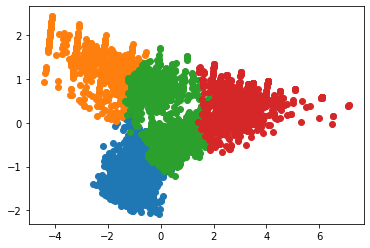

In [84]:
import matplotlib.pyplot as plt

for i in customer_clustering['cluster'].unique():
  tmp = pca_df.loc[pca_df['cluster']==i]
  plt.scatter(tmp[0], tmp[1])

In [85]:
customer_clustering_merged = pd.concat([customer_clustering, customer], axis=1)
grouped = customer_clustering_merged.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]
print(grouped)




   cluster  is_deleted  customer_id
0        0           0          827
1        0           1           19
2        1           0         1230
3        1           1           21
4        2           1          759
5        3           0          785
6        3           1          551


```
	mean_in_month	median_in_month	max_in_month	min_in_month	membership_period
cluster					
0	8.054608	8.039598	10.009456	6.160757	237.700946
1	4.676091	4.670264	7.231815	2.153477	1151.114309
2	3.049270	2.882740	4.745718	1.652174	308.872200
3	5.522518	5.373129	8.743263	2.686377	477.506737
```

```
 cluster  is_deleted  customer_id
0        0           0          827
1        0           1           19
2        1           0         1230
3        1           1           21
4        2           1          759
5        3           0          785
6        3           1          551
```

In [87]:
customer_clustering_merged.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,39
1,0,1,807
2,1,0,1
3,1,1,1250
4,2,0,281
5,2,1,478
6,3,0,47
7,3,1,1289


In [104]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['ym'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['ym', 'customer_id'], as_index=False).count()
uselog_months.rename(columns={'log_id': 'count'}, inplace=True)
del uselog_months['usedate']
uselog_months.head()

year_months = list(uselog['ym'].unique())
predict_data = pd.DataFrame()

for m in range(6, len(year_months)): # 最新6ヶ月分
  tmp = uselog_months.loc[uselog_months['ym']==year_months[m]]
  tmp.rename(columns={'count': 'count_pred'}, inplace=True)
  # 基準の月から過去6ヶ月分の利用回数を求める
  for offset in range(1, 7):
   tmp_before = uselog_months.loc[uselog_months["ym"]==year_months[m-offset]]
   del tmp_before["ym"]
   tmp_before.rename(columns={"count":"count_{}".format(offset-1)}, inplace=True)
   tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.dropna(inplace=True)
predict_data.reset_index(drop=True)
predict_data.head()


/Users/sasaki.kazuhiro/.asdf/installs/python/3.10.0/lib/python3.10/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,ym,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201903,AS002855,4,5.0,6.0,2.0,5.0,3.0,7.0
1,201903,AS008805,1,6.0,1.0,5.0,3.0,2.0,2.0
2,201903,AS009373,5,6.0,7.0,4.0,4.0,5.0,6.0
3,201903,AS015233,8,4.0,9.0,9.0,7.0,7.0,9.0
4,201903,AS015315,4,5.0,5.0,5.0,7.0,4.0,7.0


In [112]:
from dateutil.relativedelta import relativedelta
predict_data_merge = pd.merge(predict_data, customer[['customer_id', 'start_date']], on='customer_id', how='left')
predict_data_merge['current_date'] = pd.to_datetime(predict_data['ym'], format='%Y%m')
predict_data_merge['start_date'] = pd.to_datetime(predict_data_merge['start_date'])
predict_data_merge['period'] = predict_data_merge['current_date']- predict_data_merge['start_date']
predict_data_merge.head()


,ym,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,current_date,period
0,201903,AS002855,4,5.0,6.0,2.0,5.0,3.0,7.0,2016-11-01,2019-03-01,850 days
1,201903,AS008805,1,6.0,1.0,5.0,3.0,2.0,2.0,2018-06-07,2019-03-01,267 days
2,201903,AS009373,5,6.0,7.0,4.0,4.0,5.0,6.0,2015-11-01,2019-03-01,1216 days
3,201903,AS015233,8,4.0,9.0,9.0,7.0,7.0,9.0,2018-05-13,2019-03-01,292 days
4,201903,AS015315,4,5.0,5.0,5.0,7.0,4.0,7.0,2015-07-01,2019-03-01,1339 days


In [119]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

predict_data_merge = predict_data_merge.loc[
    predict_data_merge["start_date"] >= pd.to_datetime("20180401")
]
predict_data_merge["period_days"] = predict_data_merge["period"].dt.days
predict_data_merge.dropna(inplace=True)

model = linear_model.LinearRegression()
X = predict_data_merge[
    ["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period_days"]
]
y = predict_data_merge["count_pred"]
print(X.head())
print(y.head())
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


    count_0  count_1  count_2  count_3  count_4  count_5  period_days
1       6.0      1.0      5.0      3.0      2.0      2.0          267
3       4.0      9.0      9.0      7.0      7.0      9.0          292
35      4.0      4.0      1.0      3.0      4.0      4.0          240
37      8.0      8.0      8.0      9.0     12.0     11.0          170
58      7.0      8.0      9.0      9.0     12.0      6.0          320
1     1
3     8
35    1
37    6
58    9
Name: count_pred, dtype: int64
0.5067569118183729
0.41001259344456076


In [129]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

reg = xgb.XGBRegressor()
# ハイパーパラメータ探索
reg_cv = GridSearchCV(reg, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
reg_cv.fit(X_train, y_train)

reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(X_train, y_train)
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))

importances = pd.Series(reg.feature_importances_, index = X_train.columns)
importances = importances.sort_values()
print(importances)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.741504321337693
0.4926000920332667
count_5        0.031969
period_days    0.039511
count_4        0.051270
count_1        0.132758
count_0        0.160671
count_2        0.246338
count_3        0.337483
dtype: float32


In [121]:
coef = pd.DataFrame({'feature_names': X.columns, 'coefficent': model.coef_})
coef

,feature_names,coefficent
0,count_0,0.295755
1,count_1,0.130704
2,count_2,0.167578
3,count_3,0.221242
4,count_4,0.077006
5,count_5,0.212941
6,period_days,0.001374


In [122]:
x1 = [3,4,4,6,8,7,8]
x2 = [2,2,3,3,4,6,8]
x_pred = [x1, x2]
model.predict(x_pred)

/Users/sasaki.kazuhiro/.asdf/installs/python/3.10.0/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([3.71901264, 1.80957986])

In [123]:
uselog_months.to_csv('3/use_log_months.csv', index=False)